In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import mne
import re
import time
import shutil # for copying files
from operator import itemgetter

import torch
from torch import nn

### Pre-procesamiento de Anotaciones EEG de Expertos

In [2]:
# Load cvs
experts = ['A', 'B', 'C']
dfs = []
for expert in experts:
    df = pd.read_csv(f'../data/annotations_2017_{expert}.csv')
    dfs.append(df)

In [3]:
# Crear dataframe vacio con las columnas que queremos (1-79)
combined_df = pd.DataFrame(columns= [i for i in range(1,80)])
for row_a, row_b, row_c in zip(dfs[0].itertuples(), dfs[1].itertuples(), dfs[2].itertuples()):
    # Combinar las filas de los tres expertos en una sola mediante la moda
    combined_row = [max(row_a[i], row_b[i], row_c[i], key = [row_a[i], row_b[i], row_c[i]].count) for i in range(1,80)]
    # Añadir la fila al dataframe
    combined_df.loc[len(combined_df)] = combined_row

In [4]:
# Guardar el dataframe en un csv
combined_df.to_csv('../data/labels.csv', index = False)

In [5]:
combined_df.head(16)

,1,2,3,4,5,6,7,8,9,10,...,70,71,72,73,74,75,76,77,78,79
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# Ver si exiten columnas donde hay solo 0s
zeros = []
for i in range(1,80):
    if combined_df[i].sum() == 0:
        zeros.append(i)
print(len(zeros))

33


### Pre-procesamiento de Señales EEG

In [88]:
raw_file = "../data/eeg2.edf"
raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
data = raw.get_data()
names = raw.info['ch_names']
names = [name.upper() for name in names]
print("Names of channels: ", names)

C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\2165917144.py:2: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Names of channels:  ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG FZ-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG CZ-REF', 'EEG T3-REF', 'EEG T5-REF', 'EEG T4-REF', 'EEG T6-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG PZ-REF', 'EEG O1-REF', 'EEG O2-REF', 'ECG EKG', 'RESP EFFORT']


#### Checkeo de posibles señales EEG y tratamiento de etiquetas

In [101]:
set_of_curves = set()
import re

for i in range(1, 80):
    print(f"Processing file {i}")
    raw_file = f"../data/eeg{i}.edf"
    raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
    data = raw.get_data()
    data_curves = raw.ch_names
    data_curves = map(str.upper, data_curves)
    data_curves = [curve + "-REF" if not re.search("-REF", curve) else curve for curve in data_curves]
    data_curves = set(data_curves)
    set_of_curves = set_of_curves.union(data_curves)

Processing file 1
Processing file 2
Processing file 3


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 4
Processing file 5


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 6


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 7
Processing file 8


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 9
Processing file 10


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 11


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 12
Processing file 13


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 14
Processing file 15


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 16


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 17


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 18


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 19


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 20
Processing file 21


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 22
Processing file 23


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 24
Processing file 25


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 26
Processing file 27


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 28


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 29


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 30
Processing file 31


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 32


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 33
Processing file 34


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 35
Processing file 36


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 37
Processing file 38


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 39


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 40


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 41


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 42


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 43


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 44
Processing file 45


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 46


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 47
Processing file 48


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 49


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 50


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 51


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 52
Processing file 53


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 54
Processing file 55


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 56
Processing file 57


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 58
Processing file 59


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 60
Processing file 61


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 62
Processing file 63
Processing file 64


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 65
Processing file 66


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 67


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 68
Processing file 69


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 70


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 71
Processing file 72


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 73
Processing file 74


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 75
Processing file 76


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 77
Processing file 78


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)
C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


Processing file 79


C:\Users\sebag\AppData\Local\Temp\ipykernel_16872\1372396953.py:7: RuntimeWarning: Invalid date encountered (2000-00-00 00:00:00).
  raw = mne.io.read_raw_edf(raw_file, preload = True, verbose = False)


In [102]:
print(f"Total number of curves: {len(set_of_curves)}")
for curve in set_of_curves:
    print(curve)

Total number of curves: 21
EEG O1-REF
EEG FP1-REF
EEG F8-REF
EEG C3-REF
EEG O2-REF
EEG P3-REF
EEG T3-REF
RESP EFFORT-REF
EEG T4-REF
EEG F3-REF
EEG F4-REF
EEG P4-REF
EEG PZ-REF
EEG F7-REF
EEG T5-REF
EEG CZ-REF
ECG EKG-REF
EEG FP2-REF
EEG C4-REF
EEG T6-REF
EEG FZ-REF


In [103]:
all_labels = pd.read_csv('../data/labels.csv')

In [117]:
print(all_labels.iloc[:, 6].values.astype('float'))

[ 1.  1.  1. ... nan nan nan]


Lo siguiente es para plotear una canal especifico de los datos en un tiempo predefinido

In [ ]:

fig, ax = plt.subplots(figsize=[15, 5])
start_time = 15
end_time = 16

ax.plot(raw.get_data(picks=['EEG Fp2-REF'], tmin=start_time, tmax=end_time).T)
plt.show()

In [ ]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1-REF, EEG Fp2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2011-11-11 11:11:11 UTC
 nchan: 21
 projs: []
 sfreq: 256.0 Hz
 subject_info: 1 item (dict)
>

### Gráfico de librería MNE para un individuo

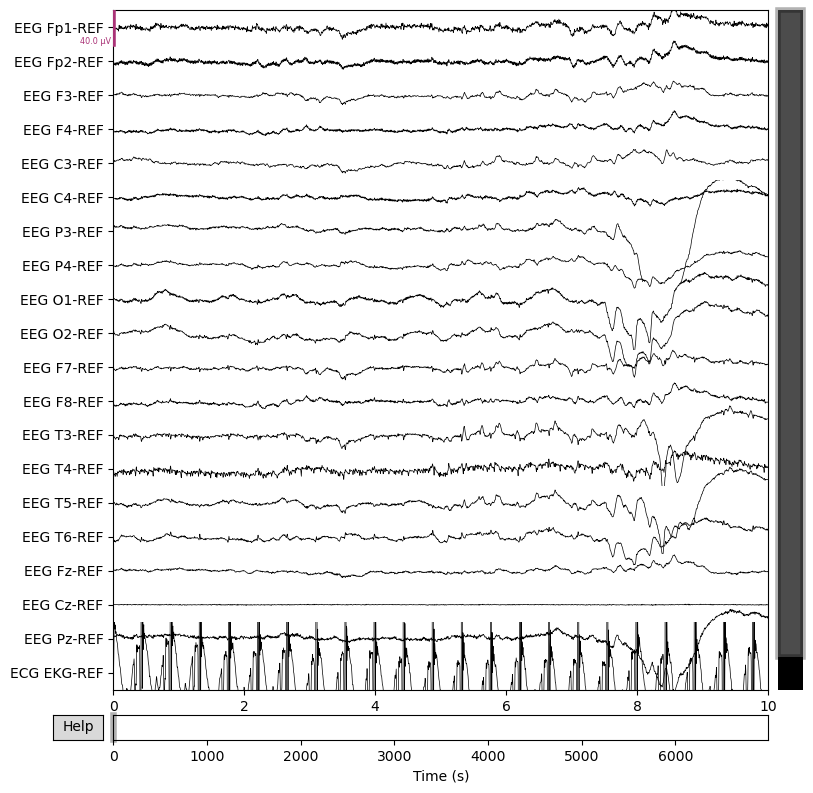

Channels marked as bad:
none
Attempting to create new mne-python configuration file:
C:\Users\simon\.mne\mne-python.json
Channels marked as bad:
['EEG O2-REF']


In [ ]:
raw.plot(show_scrollbars=True)